In [1]:
# To add a new cell, type '# %%'
# To add a new markdown cell, type '# %% [markdown]'
# %%
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy.fftpack import dct
from scipy.fftpack import idct



 #### -- 모델 준비

In [2]:
# 원전 내부의 충돌체 정보를 네개의 센서 정보만으로 특정해내기
# 데이터 출처 : https://dacon.io/competitions/official/235614/overview/description/
train_features = pd.read_csv('D:/Data/KAERI_dataset/train_features.csv')
train_target = pd.read_csv('D:/Data/KAERI_dataset/train_target.csv')



In [3]:
train_features.shape, train_target.shape



((1050000, 6), (2800, 5))

In [4]:
train_features.head()

,id,Time,S1,S2,S3,S4
0,0,0.000000,0.0,0.0,0.0,0.0
1,0,0.000004,0.0,0.0,0.0,0.0
2,0,0.000008,0.0,0.0,0.0,0.0
3,0,0.000012,0.0,0.0,0.0,0.0
4,0,0.000016,0.0,0.0,0.0,0.0


<AxesSubplot:xlabel='Time', ylabel='S4'>

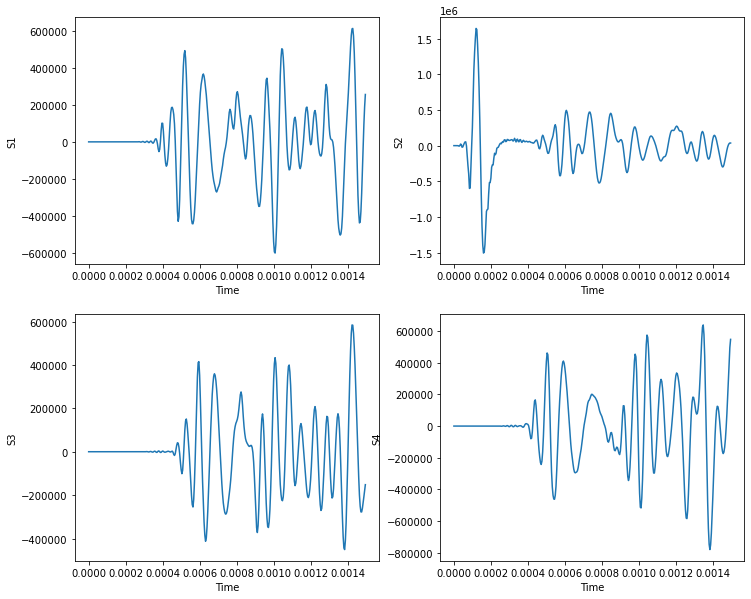

In [5]:
# 같은 인덱스(같은 충돌체)의 센서 정보를 시각화 해서 비교
# 이 파장들을 푸리에 트랜스폼 시켜서, 근사적으로 amplitude가 큰 경우만 몇가지 추려내 feature로 쓸 수 있을까?
plt.figure(figsize=(12,10))
plt.subplot(2,2,1)
sns.lineplot(data=train_features.loc[train_features['id']==10],x='Time',y='S1')

plt.subplot(2,2,2)
sns.lineplot(data=train_features.loc[train_features['id']==10],x='Time',y='S2')

plt.subplot(2,2,3)
sns.lineplot(data=train_features.loc[train_features['id']==10],x='Time',y='S3')

plt.subplot(2,2,4)
sns.lineplot(data=train_features.loc[train_features['id']==10],x='Time',y='S4')

In [6]:
train_features.loc[train_features['id']==10,'Time'].shape[0]

375

In [7]:
train_features.loc[train_features['id']==10,'S1'].values

array([ 0.000000e+00,  0.000000e+00,  0.000000e+00,  0.000000e+00,
        0.000000e+00,  0.000000e+00,  0.000000e+00,  0.000000e+00,
        0.000000e+00,  0.000000e+00,  0.000000e+00,  0.000000e+00,
        0.000000e+00,  0.000000e+00,  0.000000e+00,  0.000000e+00,
        0.000000e+00,  0.000000e+00,  0.000000e+00,  0.000000e+00,
        0.000000e+00,  0.000000e+00,  0.000000e+00,  0.000000e+00,
        0.000000e+00,  7.289906e-08,  5.706967e-07,  2.938536e-06,
        1.663324e-05,  7.646967e-05,  3.486072e-04,  1.445043e-03,
        5.365218e-03,  1.832027e-02,  5.737649e-02,  1.691780e-01,
        4.581975e-01,  1.161751e+00,  2.719724e+00,  5.836855e+00,
        1.154249e+01,  2.030301e+01,  3.208792e+01,  4.273950e+01,
        4.578627e+01,  3.003994e+01, -1.232607e+01, -8.296474e+01,
       -1.512540e+02, -1.920757e+02, -1.572109e+02, -4.281068e+01,
        8.394468e+01,  1.546614e+02,  1.087522e+02,  4.159132e+00,
       -1.678964e+01,  8.693779e+01,  1.859826e+02,  1.325555e

In [8]:
# scipy에서 Discrete Cosine Transform을 사용, 원하는 만큼만 잘라낼 수 있게 함수 설정
def fourier_trsf(data,sensor,id=10,cutoff=65):
	cond_id = data['id']==id
	wave = data.loc[cond_id,sensor].values
	time = data.loc[cond_id,'Time']
	fft_wave = dct(wave, type=2,n=time.shape[0])
	freq = np.fft.fftfreq(wave.size,d=0.000004)
	cw = np.copy(fft_wave)
	cw[cutoff:]=0
	fft_wave_2 = np.real(idct(cw))
	
	return {"cw":cw[:cutoff],"fft":fft_wave, "freq":freq, "fft_cutoff":fft_wave_2, "time":time, "wave":wave}

In [9]:
amp_w_0_s1 = fourier_trsf(data=train_features,sensor='S1',id=0,cutoff=1)['fft'][0:40]
freq_w_0_s1 = fourier_trsf(data=train_features,sensor='S1',id=0,cutoff=1)['freq'][0:40]
df_w_0_s1 = pd.DataFrame([freq_w_0_s1,amp_w_0_s1]).T
df_w_0_s1.columns = ['frequency','amplitude']
df_w_0_s1
# frequency는 id별로 전부 시간 기록 간격이 동일 하기 때문에 다르지 않음
# frequency정보는 amplitude를 기록하는 순서만 잘 지켜 주면 됨!
# 대신 문제는... 적어도 40개는 잡아줘야 한다는 건데, 이러면 특성만 160개 추가
# id=10 같이 복잡한 케이스는... 50개는 잡아줘야 하네 ㅋㅋ 200개 추가요!
# 전부 잡을 수는 없다. 일단 40개 정도만 넣어주자
# 꼭 다 넣을 필요는 없잖아? 제일 amplitude가 큰것만 넣어봐?

# 전체 id에 대해서, 가장 큰 apmlitude를 갖는 frequency를 30개씩만 뽑기
# 그렇게 뽑은 목록들을 set로 만들어서 교집합이 존재하는지 확인
# 만약에 꽤 많은 교집합이 남는다면, 그게 이 원자로 내부의 형태에 맞는 주파수일 가능성이 높다
# 해당 주파수들만 뽑아서 feature로 삼기!

,frequency,amplitude
0,0.000000,-2.312284e+05
1,666.666667,6.609213e+05
2,1333.333333,-2.045210e+06
3,2000.000000,2.221783e+06
4,2666.666667,1.755566e+06
5,3333.333333,-3.613818e+06
6,4000.000000,-2.947640e+06
7,4666.666667,3.450157e+06
8,5333.333333,5.556081e+06
9,6000.000000,8.788646e+03


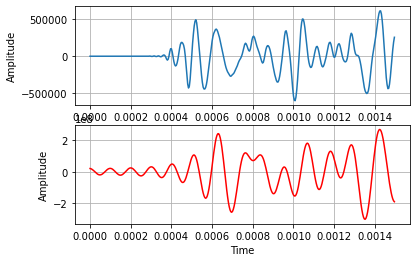

In [10]:
w0 = fourier_trsf(data=train_features,sensor='S1',id=10,cutoff=30)

fig, ax = plt.subplots(2, 1)

ax[0].plot(w0['time'], w0['wave'])
ax[0].set_xlabel('Time')
ax[0].set_ylabel('Amplitude')
ax[0].grid(True)

ax[1].plot(w0['time'], w0['fft_cutoff'], 'r') 
ax[1].set_xlabel('Time')
ax[1].set_ylabel('Amplitude')
ax[1].grid(True)

plt.show()

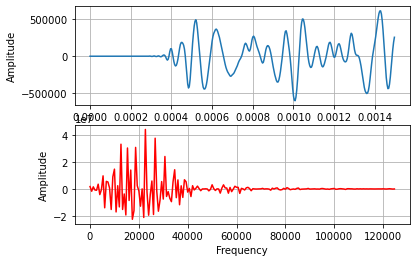

In [11]:
w0 = fourier_trsf(data=train_features,sensor='S1',id=10,cutoff=30)

fig, ax = plt.subplots(2, 1)

ax[0].plot(w0['time'], w0['wave'])
ax[0].set_xlabel('Time')
ax[0].set_ylabel('Amplitude')
ax[0].grid(True)

ax[1].plot(w0['freq'][:int(375/2)+1], w0['fft'][:int(375/2)+1], 'r') 
ax[1].set_xlabel('Frequency')
ax[1].set_ylabel('Amplitude')
ax[1].grid(True)

plt.show()

In [12]:
amp_w_0_s1 = fourier_trsf(data=train_features,sensor='S1',id=0,cutoff=1)['fft'][0:int(375/2)+1]
freq_w_0_s1 = fourier_trsf(data=train_features,sensor='S1',id=0,cutoff=1)['freq'][0:int(375/2)+1]
df_w_0_s1 = pd.DataFrame([freq_w_0_s1,amp_w_0_s1]).T
df_w_0_s1.columns = ['frequency','amplitude']
df_w_0_s1['abs_amp'] = abs(df_w_0_s1['amplitude'])
freq_set = set()
set_0 = set(list(df_w_0_s1.sort_values(by='abs_amp',ascending=False).head(30).index))
# 굳이 frequency로 뽑을 필요도 없겠다. 순서만 알면 됨. 그냥 index번호를 뽑아버리자

In [13]:
# 함수로 짜보자!
# 상위 40개에서 겹치는 걸 찾으려고 하면... 당연하지만
# 없다! 그런건 없어! 
# 하지만 방법을 반대로 바꿔보자, 상위 40개에 절대 들어오지 않는 freq는 있을까?
# 공간이 제한되어 있기 때문에, 거의 나타나지 않는 freq가 있을 수 있다!
def find_unique_freq(data0,head=40):
    data = data0.copy()
    id_list = np.array(data['id'].unique())
    set_dict = {}
    n = data[data['id']==0].shape[0]
    nn = int(n/2)+1

    for s in ['S1','S2','S3','S4']:
        min_set = set(range(0,nn))
        for i in id_list:
            fft_wave = fourier_trsf(data=data,sensor=s,id=i)
            freq = fft_wave['freq'][0:nn]
            amp = fft_wave['fft'][0:nn]
            abs_amp = abs(amp)

            df_wave = pd.DataFrame([freq,amp,abs_amp]).T
            df_wave.columns = ['freq','amp','abs_amp']
            set_i = set(df_wave.sort_values(by='abs_amp',ascending=False).head(head).index)

            min_set = min_set - set_i

        set_dict[s]=min_set
    return set_dict


In [14]:
# rmv_freq = find_unique_freq(train_features)
# 계산이 좀 걸리지만, 이정도는 오케이

In [15]:
# 좋아! 있다! 그것도 꽤 많다! 96개
# 일단 188개에서, 96개를 빼버리자, 그러면 남는게 92개
# tot_rmv_freq = rmv_freq['S1'] & rmv_freq['S2'] & rmv_freq['S3'] & rmv_freq['S4']
# len(tot_rmv_freq)

In [16]:
# 한번 더 해보자, 이번엔 상의 30개에 들어오지 않는 freq를 찾아서 제외시키자
# rmv_freq_und30 = find_unique_freq(train_features,head=30)
# tot_rmv_freq_und30 = rmv_freq_und30['S1'] & rmv_freq_und30['S2'] & rmv_freq_und30['S3'] & rmv_freq_und30['S4']
# len(tot_rmv_freq_und30)
# 오케이! 108개다. 이만큼을 제외 시키면, 80개가 남는다
# 이정도면 해볼만도...? 

In [17]:
# 게다가 이겈ㅋㅋㅋ 0~79까지가 딱 남았네
# freq_idx_80 = np.array(set(range(0,188)) - tot_rmv_freq_und30)
# freq_idx_80

In [18]:
# 한번만 더 해보자! 상위 20개
# 112개 제외라, 76개가 남는다. 딱히 더 나아지진 않네
# rmv_freq_und20 = find_unique_freq(train_features,head=20)
# tot_rmv_freq_und20 = rmv_freq_und20['S1'] & rmv_freq_und20['S2'] & rmv_freq_und20['S3'] & rmv_freq_und20['S4']
# len(tot_rmv_freq_und20)

In [19]:
# freq_idx_76 = np.array(set(range(0,188)) - tot_rmv_freq_und20)
# freq_idx_76

In [20]:
# 실험 삼아 하나만 더 해보자, 상위 5개!
# rmv_freq_und5 = find_unique_freq(train_features,head=5)
# tot_rmv_freq_und5 = rmv_freq_und5['S1'] & rmv_freq_und5['S2'] & rmv_freq_und5['S3'] & rmv_freq_und5['S4']
# len(tot_rmv_freq_und5)

In [21]:
# freq_idx_60 = np.array(set(range(0,188)) - tot_rmv_freq_und5)
# freq_idx_60

In [22]:
# 65번째 까지(0~64) 킵해보자
# 일단 feature로 만들어서 넣어주는 함수를 짜자
# column이름은 f1_0~f4_65같은 식으로 넣기
def fourier_feature(data0,cutoff=65):
    data = data0.copy()
    id_list = np.array(data['id'].unique())
    df_id = pd.DataFrame(id_list,columns=['id'])
    df_list = [df_id]

    for s in ['S1','S2','S3','S4']:
        df_s = []
        for i in id_list:
            fft_wave = fourier_trsf(data=data,sensor=s,id=i,cutoff=cutoff)
            amp = fft_wave['cw']
            
            df_wave = pd.DataFrame(amp).T
            df_wave.columns = [s+'_f'+str(n) for n in range(cutoff)]
            df_s.append(df_wave)
        df_sensor = pd.concat(df_s,axis=0).reset_index(drop=True)
        df_list.append(df_sensor)

    df_tot = pd.concat(df_list,axis=1)

    return df_tot

In [23]:
# df_fft65 = fourier_feature(train_features,cutoff=65)
# df_fft65

In [24]:
# 확인 해보니, S3가 먼저 신호를 받은 경우가 한번도 없는 것으로 나온다
# 그래서 S3가 항상 고려되지 않은채로 분류 된 것...
# 추후에도 S3값이 고려 될 수 있게, 축을 새로 잡아주기
def reset_axis(data0,new_axis=('A','B','C','D')):
    data = data0.copy()
    
    # A=(S1+S2+S3+S4)/4, B=(S1+S2-S3-S4)/4, C=(S1-S2-S3+S4)/4, D=(S1-S2+S3-S4)/4
    ns1,ns2,ns3,ns4 = data['S1'],data['S2'],data['S3'],data['S4']
    data[new_axis[0]] = (ns1+ns2+ns3+ns4)/4
    data[new_axis[1]] = (ns1+ns2-ns3-ns4)/4
    data[new_axis[2]] = (ns1-ns2-ns3+ns4)/4
    data[new_axis[3]] = (ns1-ns2+ns3-ns4)/4
    data = data.drop(['Time','S1','S2','S3','S4'],axis=1)
    
    return data



In [25]:
# 앞서 수행했던 데이터 전처리 및 feature engineering을 수행해주는 함수
def feature_eng_df(data,cutoff=80):   
    cond = (data['S1'] != 0) | (data['S2'] != 0) | (data['S3'] != 0) | (data['S4'] != 0)
    data_active = data[cond]
    data_active = data_active.drop_duplicates(['id'],keep='first')
    
    new_axis = ('A','B','C','D')
    data_new = reset_axis(data,new_axis=new_axis)
    cond_new = (data_new['A'] != 0) | (data_new['B'] != 0) | (data_new['C'] != 0) | (data_new['D'] != 0)  
    data_active_new = data_new[cond_new]
    data_active_new = data_active_new.drop_duplicates(['id'],keep='first')
    
    data_active = data_active.merge(data_active_new,on='id')
    
    for s in ['S1','S2','S3','S4']:
        min_s = data.groupby(by='id').min()[s]
        max_s = data.groupby(by='id').max()[s]
        gap_s = max_s - min_s
        gap_s = gap_s.reset_index()
        gap_s.columns = ['id','gap_'+s]
        data_active = data_active.merge(gap_s,on='id')

    data_active['Time'] = (data_active['Time']*10**6).astype('int')

    data[(data['S2'] != 0)].drop_duplicates(['id'],keep='first')[['id','Time']]

    for s in ['S1','S2','S3','S4']:
        cond = (data[s] != 0)
        active_time = data[cond].drop_duplicates(['id'],keep='first')[['id','Time']]
        active_time['Time'] = (active_time['Time']*10**6).astype('int')
        active_time.columns = ['id','active_time_'+s]
        data_active = data_active.merge(active_time,on='id')

    data_active['R12'] = (data_active['active_time_S1']+data_active['active_time_S2'])/(data_active['active_time_S3']+data_active['active_time_S4'])
    data_active['R13'] = (data_active['active_time_S1']+data_active['active_time_S3'])/(data_active['active_time_S2']+data_active['active_time_S4'])
    data_active['R14'] = (data_active['active_time_S1']+data_active['active_time_S4'])/(data_active['active_time_S2']+data_active['active_time_S3'])

    data_active['RMS_S'] = (data_active['S1']**2+data_active['S2']**2+data_active['S3']**2+data_active['S4']**2)**0.5
    data_active['RMS_gap'] = (data_active['gap_S1']**2+data_active['gap_S2']**2+data_active['gap_S3']**2+data_active['gap_S4']**2)**0.5
    data_active['RMS_time'] = (data_active['active_time_S1']**2+data_active['active_time_S2']**2+data_active['active_time_S3']**2+data_active['active_time_S4']**2)**0.5
    
    data_fft = fourier_feature(data,cutoff=cutoff)
    data_active = data_active.merge(data_fft,on='id')

    return data_active



In [26]:
df_features = feature_eng_df(train_features)
df_features.head().T



,0,1,2,3,4
id,0.000000e+00,1.000000e+00,2.000000,3.000000e+00,4.000000e+00
Time,4.000000e+01,2.000000e+01,16.000000,3.200000e+01,2.000000e+01
S1,-4.972607e-08,0.000000e+00,-0.000092,0.000000e+00,3.230998e-07
S2,-4.972607e-08,-4.104924e-07,0.000000,-1.783159e-07,0.000000e+00
S3,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00
...,...,...,...,...,...
S4_f75,1.684120e+06,-1.518072e+06,-61321.832785,-5.812756e+05,-9.751388e+05
S4_f76,2.884239e+04,-5.615888e+06,-120137.749756,-8.366543e+05,3.916767e+05
S4_f77,3.995064e+05,-1.179631e+06,99635.066101,4.095499e+05,-9.707762e+04
S4_f78,2.543315e+05,2.940736e+06,100054.862204,9.089064e+05,1.146868e+04


In [27]:
targets = list(train_target.columns)[1:]
features = list(df_features.columns)[1:]


In [28]:
df = df_features.merge(train_target,on='id')
df.head()



,id,Time,S1,S2,S3,S4,A,B,C,D,...,S4_f74,S4_f75,S4_f76,S4_f77,S4_f78,S4_f79,X,Y,M,V
0,0,40,-4.972607e-08,-4.972607e-08,0.0,0.0,-2.486304e-08,-2.486304e-08,0.000000e+00,0.000000e+00,...,-6.845378e+05,1.684120e+06,2.884239e+04,3.995064e+05,2.543315e+05,4.671553e+05,0.0,-400.0,50.0,0.4
1,1,20,0.000000e+00,-4.104924e-07,0.0,0.0,-1.026231e-07,-1.026231e-07,1.026231e-07,1.026231e-07,...,-5.314059e+05,-1.518072e+06,-5.615888e+06,-1.179631e+06,2.940736e+06,-5.467193e+06,400.0,0.0,100.0,1.0
2,2,16,-9.210808e-05,0.000000e+00,0.0,0.0,-2.302702e-05,-2.302702e-05,-2.302702e-05,-2.302702e-05,...,4.349310e+04,-6.132183e+04,-1.201377e+05,9.963507e+04,1.000549e+05,2.279359e+05,-300.0,-200.0,25.0,0.4
3,3,32,0.000000e+00,-1.783159e-07,0.0,0.0,-4.457897e-08,-4.457897e-08,4.457897e-08,4.457897e-08,...,-4.198138e+05,-5.812756e+05,-8.366543e+05,4.095499e+05,9.089064e+05,1.626792e+05,200.0,-100.0,150.0,0.4
4,4,20,3.230998e-07,0.000000e+00,0.0,0.0,8.077495e-08,8.077495e-08,8.077495e-08,8.077495e-08,...,-1.710859e+06,-9.751388e+05,3.916767e+05,-9.707762e+04,1.146868e+04,7.479534e+05,-300.0,-100.0,150.0,0.4


In [29]:
# 데이터를 학습용, 검증용으로 분리
df_train, df_val = train_test_split(df[1:],test_size=0.2,train_size=0.8,random_state=2)
df_train.shape, df_val.shape, df.shape



((2239, 348), (560, 348), (2800, 348))

In [30]:
y_train = df_train[targets]
X_train = df_train[features]

y_val = df_val[targets]
X_val = df_val[features]



In [31]:
# dacon에서 제공하는 평가 지표 함수. 낮을 수록 좋은 값.
def kaeri_metric(y_true, y_pred):
    '''
    y_true: dataframe with true values of X,Y,M,V
    y_pred: dataframe with pred values of X,Y,M,V
    
    return: KAERI metric
    '''    
    return 0.5 * E1(y_true, y_pred) + 0.5 * E2(y_true, y_pred)

### E1과 E2는 아래에 정의됨 ###

def E1(y_true, y_pred):
    '''
    y_true: dataframe with true values of X,Y,M,V
    y_pred: dataframe with pred values of X,Y,M,V
    
    return: distance error normalized with 2e+04
    '''
    _t, _p = np.array(y_true)[:,:2], np.array(y_pred)[:,:2]
    
    return np.mean(np.sum(np.square(_t - _p), axis = 1) / 2e+04)

def E2(y_true, y_pred):
    '''
    y_true: dataframe with true values of X,Y,M,V
    y_pred: dataframe with pred values of X,Y,M,V
    
    return: sum of mass and velocity's mean squared percentage error
    '''
    _t, _p = np.array(y_true)[:,2:], np.array(y_pred)[:,2:]
            
    return np.mean(np.sum(np.square((_t - _p) / (_t + 1e-06)), axis = 1))



In [32]:
# Multi output regressor를 이용해서 XGB regressor를 사용
model = MultiOutputRegressor(XGBRegressor(n_estimators=200, learning_rate=0.1, gamma=0, subsample=0.75,max_depth=8))



In [33]:
# XGB에 사용하기 위해서, array 형태로 전부 변환
# dX_train = X_train.to_numpy()
# dX_val = X_val.to_numpy()
# dy_train = y_train.to_numpy()
# dy_val = y_val.to_numpy()



In [34]:
model.fit(X_train,y_train)



MultiOutputRegressor(estimator=XGBRegressor(base_score=None, booster=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, gamma=0,
                                            gpu_id=None, importance_type='gain',
                                            interaction_constraints=None,
                                            learning_rate=0.1,
                                            max_delta_step=None, max_depth=8,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, reg_alpha=None,
                                            r

In [35]:
y_train_pred_xgb = model.predict(X_train)
y_val_pred_xgb = model.predict(X_val)



In [36]:
# 스코어 계산
xgb_kaeri_score_train = kaeri_metric(y_train,y_train_pred_xgb)
xgb_mae_train = mean_absolute_error(y_train,y_train_pred_xgb)
xgb_mse_train = mean_squared_error(y_train,y_train_pred_xgb)
xgb_kaeri_score_val = kaeri_metric(y_val,y_val_pred_xgb)
xgb_mae_val = mean_absolute_error(y_val,y_val_pred_xgb)
xgb_mse_val = mean_squared_error(y_val,y_val_pred_xgb)

xgb_score = pd.DataFrame(['xgb',xgb_kaeri_score_train,xgb_mae_train, xgb_mse_train, xgb_kaeri_score_val,xgb_mae_val, xgb_mse_val]).T
xgb_score.columns=['idx','kaeri_score_train', 'mae_train', 'mse_train', 'kaeri_score_val', 'mae_val', 'mse_val']
xgb_score

,idx,kaeri_score_train,mae_train,mse_train,kaeri_score_val,mae_val,mse_val
0,xgb,0.000001,0.014042,0.000837,0.012386,1.925507,32.015442


In [37]:
# 전체 데이터로 다시 한번 학습
X_data = df[features]
y_data = df[targets]

In [38]:
X_data

,Time,S1,S2,S3,S4,A,B,C,D,gap_S1,...,S4_f70,S4_f71,S4_f72,S4_f73,S4_f74,S4_f75,S4_f76,S4_f77,S4_f78,S4_f79
0,40,-4.972607e-08,-4.972607e-08,0.0,0.000000e+00,-2.486304e-08,-2.486304e-08,0.000000e+00,0.000000e+00,550552.4,...,5.071280e+05,-3.233548e+05,-7.884806e+05,-7.411061e+05,-6.845378e+05,1.684120e+06,2.884239e+04,3.995064e+05,2.543315e+05,4.671553e+05
1,20,0.000000e+00,-4.104924e-07,0.0,0.000000e+00,-1.026231e-07,-1.026231e-07,1.026231e-07,1.026231e-07,1896170.9,...,6.810700e+06,-3.634670e+06,2.689998e+06,7.344554e+06,-5.314059e+05,-1.518072e+06,-5.615888e+06,-1.179631e+06,2.940736e+06,-5.467193e+06
2,16,-9.210808e-05,0.000000e+00,0.0,0.000000e+00,-2.302702e-05,-2.302702e-05,-2.302702e-05,-2.302702e-05,747684.0,...,8.821958e+03,1.435433e+05,-2.311452e+05,7.231243e+05,4.349310e+04,-6.132183e+04,-1.201377e+05,9.963507e+04,1.000549e+05,2.279359e+05
3,32,0.000000e+00,-1.783159e-07,0.0,0.000000e+00,-4.457897e-08,-4.457897e-08,4.457897e-08,4.457897e-08,709331.0,...,1.112344e+06,1.235585e+06,-1.392704e+06,-3.260174e+05,-4.198138e+05,-5.812756e+05,-8.366543e+05,4.095499e+05,9.089064e+05,1.626792e+05
4,20,3.230998e-07,0.000000e+00,0.0,0.000000e+00,8.077495e-08,8.077495e-08,8.077495e-08,8.077495e-08,1346981.9,...,8.935400e+05,-3.211971e+05,4.581315e+05,9.788012e+05,-1.710859e+06,-9.751388e+05,3.916767e+05,-9.707762e+04,1.146868e+04,7.479534e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2795,16,0.000000e+00,0.000000e+00,0.0,3.893916e-07,9.734790e-08,-9.734790e-08,9.734790e-08,-9.734790e-08,1491891.5,...,2.165615e+06,-2.254205e+05,5.585104e+05,-4.278212e+05,1.117979e+05,-4.899646e+05,4.390309e+06,3.397431e+05,5.319516e+05,2.148802e+06
2796,8,1.343907e-06,0.000000e+00,0.0,0.000000e+00,3.359768e-07,3.359768e-07,3.359768e-07,3.359768e-07,783892.5,...,-3.605822e+04,-7.050914e+04,6.265161e+04,-3.835399e+04,-4.101862e+03,1.227300e+05,-2.112372e+04,1.014502e+04,8.566846e+04,-2.674167e+05
2797,28,0.000000e+00,0.000000e+00,0.0,-4.435977e-08,-1.108994e-08,1.108994e-08,-1.108994e-08,1.108994e-08,236713.7,...,3.955342e+05,1.167296e+05,1.722399e+05,1.448855e+05,1.616543e+04,-2.410745e+05,-9.700185e+04,-9.958476e+04,3.896432e+04,-5.656378e+04
2798,24,0.000000e+00,0.000000e+00,0.0,-9.894686e-06,-2.473672e-06,2.473672e-06,-2.473672e-06,2.473672e-06,1164571.3,...,-1.084590e+06,-3.242183e+05,-9.165169e+04,-5.666201e+04,2.487780e+05,-5.085879e+05,-9.514115e+05,-1.113395e+06,-1.085222e+06,-1.413796e+05


In [39]:
model.fit(X_data,y_data)

MultiOutputRegressor(estimator=XGBRegressor(base_score=None, booster=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, gamma=0,
                                            gpu_id=None, importance_type='gain',
                                            interaction_constraints=None,
                                            learning_rate=0.1,
                                            max_delta_step=None, max_depth=8,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, reg_alpha=None,
                                            r

In [40]:
y_pred = model.predict(X_data)
kaeri_metric(y_data,y_pred)

1.2025025727808089e-06

In [41]:
test_features = pd.read_csv('D:/Data/KAERI_dataset/test_features.csv')
test_data = feature_eng_df(test_features)[features]
test_data.head()

,Time,S1,S2,S3,S4,A,B,C,D,gap_S1,...,S4_f70,S4_f71,S4_f72,S4_f73,S4_f74,S4_f75,S4_f76,S4_f77,S4_f78,S4_f79
0,28,-0.000017,0.000000,0.0,0.000000e+00,-4.337703e-06,-4.337703e-06,-4.337703e-06,-4.337703e-06,1064141.6,...,1.006397e+05,9.470265e+04,-143646.985942,100670.440589,6.072666e+05,317574.421060,-247792.308285,5.175151e+05,-8.727789e+05,-118520.156559
1,12,0.000000,-0.000396,0.0,0.000000e+00,-9.901310e-05,-9.901310e-05,9.901310e-05,9.901310e-05,600223.4,...,-1.706261e+06,1.297139e+06,465284.331227,-254155.678098,-1.340125e+06,642820.157086,-278813.247124,2.449227e+05,-1.868820e+05,194530.575107
2,24,0.000000,0.000000,0.0,6.836355e-08,1.709089e-08,-1.709089e-08,1.709089e-08,-1.709089e-08,398824.2,...,5.155221e+05,-2.107417e+03,-50054.493437,20612.102339,4.880254e+05,-680552.993447,-791442.879399,-5.023947e+05,-2.803123e+05,-160021.922882
3,12,0.000000,0.000000,0.0,7.064889e-06,1.766222e-06,-1.766222e-06,1.766222e-06,-1.766222e-06,271699.8,...,-1.255778e+05,1.957328e+05,-206069.496004,87631.967031,-4.454100e+05,-523689.727866,-698358.972856,-3.883270e+05,-1.644202e+05,-64780.094646
4,16,0.000000,0.000000,0.0,5.848906e-07,1.462226e-07,-1.462226e-07,1.462226e-07,-1.462226e-07,783081.2,...,4.704295e+04,1.007625e+05,-230636.080972,-583374.533805,-1.513824e+06,-542773.214225,-134457.634119,-1.462209e+06,-1.010424e+06,949229.676286


In [42]:
y_test_pred = model.predict(test_data)

In [43]:
submit = pd.read_csv('D:/Data/KAERI_dataset/sample_submission.csv')
for i in range(4):
	submit.iloc[:,i+1] = y_test_pred[:,i]
submit.head()

,id,X,Y,M,V
0,2800,-299.968323,95.642159,111.438438,0.389541
1,2801,300.256683,-199.998199,76.106224,0.401465
2,2802,-201.366180,99.892891,31.743324,0.362391
3,2803,199.948029,201.400803,25.196455,0.344063
4,2804,-100.000572,199.835602,137.652206,0.505583


In [44]:
submit.to_csv('D:/Data/KAERI_dataset/submission_xgb_fourier_80.csv', index = False)
# public : 
# private : 
print("Done!")


Done!


 #### -- shap 결론
 x에는 R14가, y에는 R12가 가장 큰 영향력을 끼친다.

 이를 통해 유추해볼 때, x축을 기준으로 좌/우로 나누었을 때는 (S2,S3)/(S1,S4)

 y축을 기준으로 위/아래를 나누었을 때는 (S1,S2)/(S3,S4)가 위치해 있다고 볼 수 있다.


 | S2 | S1 |

 -ㅡ-ㅡ-ㅡ-

 | S3 | S4 |

 ...와 같은 형태

 x,y 좌표에는 주로 시간관련 변수가
 v에는 주로 신호의 세기 관련 변수가 영향을 주었다.

 각각의 예측을 평가해봤을 때, 어느 것이 부족한지에 따라 추가해야할 변수로 시간을 넣을지 신호의 세기를 넣을지 결정 할 수 있을 것으로 보인다.

 m의 경우에는 두가지 모두가 중요했고, 가장 복잡한 형태를 보여주었다.

 다른 세가지 변수를 최대한 먼저 최적화 시킨 후에, 질량을 고려하는 것이 좋을 것으로 보인다


In [45]:
model_rf = RandomForestRegressor(max_depth=15,min_samples_split=2,min_samples_leaf=1,criterion='mae',max_features='sqrt',n_estimators=1000,oob_score=True,random_state=2,n_jobs=3)

In [46]:
model_rf.fit(X_train,y_train)

RandomForestRegressor(criterion='mae', max_depth=15, max_features='sqrt',
                      n_estimators=1000, n_jobs=3, oob_score=True,
                      random_state=2)

In [47]:
y_pred_val_rf = model_rf.predict(X_val)
kaeri_metric(y_val,y_pred_val_rf)

0.20269134397623298

In [48]:
y_pred_train_rf = model_rf.predict(X_train)
kaeri_metric(y_train,y_pred_train_rf)

0.03260991589011503

<AxesSubplot:>

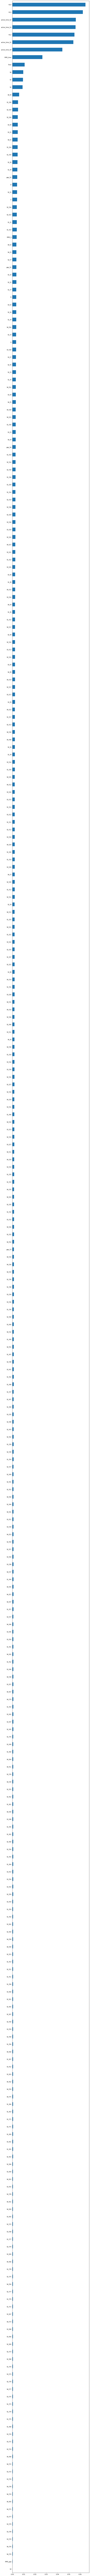

In [49]:
plt.figure(figsize=(10,len(model_rf.feature_importances_)))
pd.Series(model_rf.feature_importances_,X_train.columns).sort_values().plot.barh()

In [50]:
model_rf2 = RandomForestRegressor(max_depth=None,min_samples_split=2,min_samples_leaf=1,criterion='mae',max_features='sqrt',n_estimators=1000,oob_score=True,random_state=2,n_jobs=3)

In [51]:
model_rf2.fit(X_train,y_train)

RandomForestRegressor(criterion='mae', max_features='sqrt', n_estimators=1000,
                      n_jobs=3, oob_score=True, random_state=2)

In [52]:
y_pred_val_rf2 = model_rf2.predict(X_val)
kaeri_metric(y_val,y_pred_val_rf)

0.20269134397623298

In [53]:
y_pred_train_rf2 = model_rf2.predict(X_train)
kaeri_metric(y_train,y_pred_train_rf)

0.03260991589011503

<AxesSubplot:>

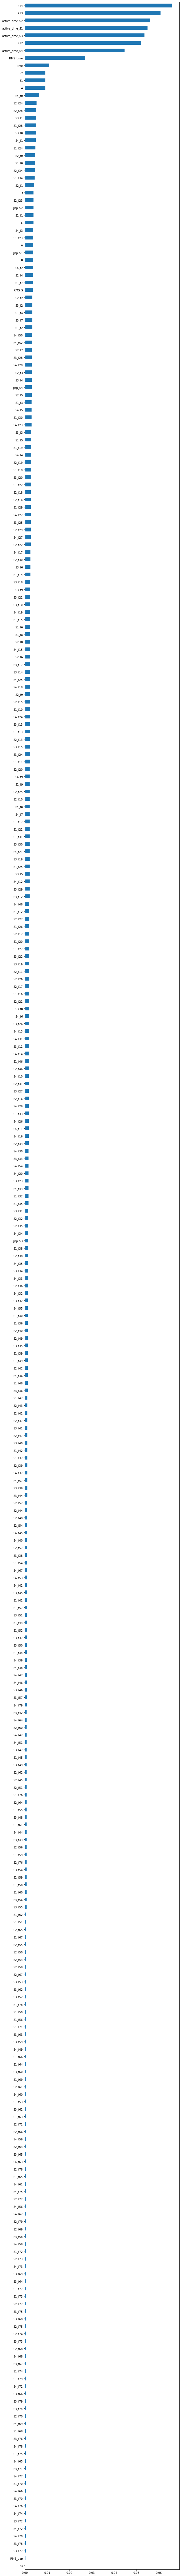

In [54]:
plt.figure(figsize=(10,len(model_rf2.feature_importances_)//2))
pd.Series(model_rf2.feature_importances_,X_train.columns).sort_values().plot.barh()

In [55]:
test_features = pd.read_csv('D:/Data/KAERI_dataset/test_features.csv')
test_data = feature_eng_df(test_features)[features]
test_data.head()

,Time,S1,S2,S3,S4,A,B,C,D,gap_S1,...,S4_f70,S4_f71,S4_f72,S4_f73,S4_f74,S4_f75,S4_f76,S4_f77,S4_f78,S4_f79
0,28,-0.000017,0.000000,0.0,0.000000e+00,-4.337703e-06,-4.337703e-06,-4.337703e-06,-4.337703e-06,1064141.6,...,1.006397e+05,9.470265e+04,-143646.985942,100670.440589,6.072666e+05,317574.421060,-247792.308285,5.175151e+05,-8.727789e+05,-118520.156559
1,12,0.000000,-0.000396,0.0,0.000000e+00,-9.901310e-05,-9.901310e-05,9.901310e-05,9.901310e-05,600223.4,...,-1.706261e+06,1.297139e+06,465284.331227,-254155.678098,-1.340125e+06,642820.157086,-278813.247124,2.449227e+05,-1.868820e+05,194530.575107
2,24,0.000000,0.000000,0.0,6.836355e-08,1.709089e-08,-1.709089e-08,1.709089e-08,-1.709089e-08,398824.2,...,5.155221e+05,-2.107417e+03,-50054.493437,20612.102339,4.880254e+05,-680552.993447,-791442.879399,-5.023947e+05,-2.803123e+05,-160021.922882
3,12,0.000000,0.000000,0.0,7.064889e-06,1.766222e-06,-1.766222e-06,1.766222e-06,-1.766222e-06,271699.8,...,-1.255778e+05,1.957328e+05,-206069.496004,87631.967031,-4.454100e+05,-523689.727866,-698358.972856,-3.883270e+05,-1.644202e+05,-64780.094646
4,16,0.000000,0.000000,0.0,5.848906e-07,1.462226e-07,-1.462226e-07,1.462226e-07,-1.462226e-07,783081.2,...,4.704295e+04,1.007625e+05,-230636.080972,-583374.533805,-1.513824e+06,-542773.214225,-134457.634119,-1.462209e+06,-1.010424e+06,949229.676286


In [56]:
y_test_pred = model_rf2.predict(test_data)

In [57]:
submit = pd.read_csv('D:/Data/KAERI_dataset/sample_submission.csv')
for i in range(4):
	submit.iloc[:,i+1] = y_test_pred[:,i]
submit.head()

,id,X,Y,M,V
0,2800,-199.3,-66.2,87.4875,0.4710
1,2801,245.4,-237.3,80.0625,0.4624
2,2802,-209.1,132.4,77.0750,0.3457
3,2803,149.8,204.4,71.2500,0.3584
4,2804,-128.1,176.8,94.1375,0.4380


In [58]:
submit.to_csv('D:/Data/KAERI_dataset/submission_rf_fourier_80.csv', index = False)
# public : 
# private : 
print("Done!")

Done!


In [59]:
# 앞서 수행했던 데이터 전처리 및 feature engineering을 수행해주는 함수
def feature_eng_df(data,cutoff=100):   
    cond = (data['S1'] != 0) | (data['S2'] != 0) | (data['S3'] != 0) | (data['S4'] != 0)
    data_active = data[cond]
    data_active = data_active.drop_duplicates(['id'],keep='first')
    
    new_axis = ('A','B','C','D')
    data_new = reset_axis(data,new_axis=new_axis)
    cond_new = (data_new['A'] != 0) | (data_new['B'] != 0) | (data_new['C'] != 0) | (data_new['D'] != 0)  
    data_active_new = data_new[cond_new]
    data_active_new = data_active_new.drop_duplicates(['id'],keep='first')
    
    data_active = data_active.merge(data_active_new,on='id')
    
    for s in ['S1','S2','S3','S4']:
        min_s = data.groupby(by='id').min()[s]
        max_s = data.groupby(by='id').max()[s]
        gap_s = max_s - min_s
        gap_s = gap_s.reset_index()
        gap_s.columns = ['id','gap_'+s]
        data_active = data_active.merge(gap_s,on='id')

    data_active['Time'] = (data_active['Time']*10**6).astype('int')

    data[(data['S2'] != 0)].drop_duplicates(['id'],keep='first')[['id','Time']]

    for s in ['S1','S2','S3','S4']:
        cond = (data[s] != 0)
        active_time = data[cond].drop_duplicates(['id'],keep='first')[['id','Time']]
        active_time['Time'] = (active_time['Time']*10**6).astype('int')
        active_time.columns = ['id','active_time_'+s]
        data_active = data_active.merge(active_time,on='id')

    data_active['R12'] = (data_active['active_time_S1']+data_active['active_time_S2'])/(data_active['active_time_S3']+data_active['active_time_S4'])
    data_active['R13'] = (data_active['active_time_S1']+data_active['active_time_S3'])/(data_active['active_time_S2']+data_active['active_time_S4'])
    data_active['R14'] = (data_active['active_time_S1']+data_active['active_time_S4'])/(data_active['active_time_S2']+data_active['active_time_S3'])

    data_active['RMS_S'] = (data_active['S1']**2+data_active['S2']**2+data_active['S3']**2+data_active['S4']**2)**0.5
    data_active['RMS_gap'] = (data_active['gap_S1']**2+data_active['gap_S2']**2+data_active['gap_S3']**2+data_active['gap_S4']**2)**0.5
    data_active['RMS_time'] = (data_active['active_time_S1']**2+data_active['active_time_S2']**2+data_active['active_time_S3']**2+data_active['active_time_S4']**2)**0.5
    
    data_fft = fourier_feature(data,cutoff=cutoff)
    data_active = data_active.merge(data_fft,on='id')

    return data_active



In [60]:
df_features = feature_eng_df(train_features)
df_features.head().T



,0,1,2,3,4
id,0.000000e+00,1.000000e+00,2.000000,3.000000e+00,4.000000e+00
Time,4.000000e+01,2.000000e+01,16.000000,3.200000e+01,2.000000e+01
S1,-4.972607e-08,0.000000e+00,-0.000092,0.000000e+00,3.230998e-07
S2,-4.972607e-08,-4.104924e-07,0.000000,-1.783159e-07,0.000000e+00
S3,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00
...,...,...,...,...,...
S4_f95,8.166660e+04,2.412473e+06,61170.965381,5.743404e+05,-4.948800e+05
S4_f96,9.804831e+03,6.075201e+05,-82713.556849,-1.942639e+05,-3.807754e+05
S4_f97,7.097516e+05,-2.713020e+06,109367.916945,-7.664033e+05,6.460470e+04
S4_f98,-3.673212e+05,1.024328e+06,-688367.114219,-2.633480e+05,-4.378415e+05


In [61]:
targets = list(train_target.columns)[1:]
features = list(df_features.columns)[1:]


In [62]:
df = df_features.merge(train_target,on='id')
df.head()



,id,Time,S1,S2,S3,S4,A,B,C,D,...,S4_f94,S4_f95,S4_f96,S4_f97,S4_f98,S4_f99,X,Y,M,V
0,0,40,-4.972607e-08,-4.972607e-08,0.0,0.0,-2.486304e-08,-2.486304e-08,0.000000e+00,0.000000e+00,...,7.890729e+04,8.166660e+04,9804.830582,7.097516e+05,-3.673212e+05,-493783.583682,0.0,-400.0,50.0,0.4
1,1,20,0.000000e+00,-4.104924e-07,0.0,0.0,-1.026231e-07,-1.026231e-07,1.026231e-07,1.026231e-07,...,1.850996e+06,2.412473e+06,607520.064828,-2.713020e+06,1.024328e+06,-642252.289549,400.0,0.0,100.0,1.0
2,2,16,-9.210808e-05,0.000000e+00,0.0,0.0,-2.302702e-05,-2.302702e-05,-2.302702e-05,-2.302702e-05,...,5.454972e+05,6.117097e+04,-82713.556849,1.093679e+05,-6.883671e+05,-392192.584992,-300.0,-200.0,25.0,0.4
3,3,32,0.000000e+00,-1.783159e-07,0.0,0.0,-4.457897e-08,-4.457897e-08,4.457897e-08,4.457897e-08,...,-1.759796e+03,5.743404e+05,-194263.859573,-7.664033e+05,-2.633480e+05,120823.239864,200.0,-100.0,150.0,0.4
4,4,20,3.230998e-07,0.000000e+00,0.0,0.0,8.077495e-08,8.077495e-08,8.077495e-08,8.077495e-08,...,-1.902988e+04,-4.948800e+05,-380775.406154,6.460470e+04,-4.378415e+05,516810.129541,-300.0,-100.0,150.0,0.4


In [63]:
# 데이터를 학습용, 검증용으로 분리
df_train, df_val = train_test_split(df[1:],test_size=0.2,train_size=0.8,random_state=2)
df_train.shape, df_val.shape, df.shape



((2239, 428), (560, 428), (2800, 428))

In [64]:
y_train = df_train[targets]
X_train = df_train[features]

y_val = df_val[targets]
X_val = df_val[features]



In [65]:
# dacon에서 제공하는 평가 지표 함수. 낮을 수록 좋은 값.
def kaeri_metric(y_true, y_pred):
    '''
    y_true: dataframe with true values of X,Y,M,V
    y_pred: dataframe with pred values of X,Y,M,V
    
    return: KAERI metric
    '''    
    return 0.5 * E1(y_true, y_pred) + 0.5 * E2(y_true, y_pred)

### E1과 E2는 아래에 정의됨 ###

def E1(y_true, y_pred):
    '''
    y_true: dataframe with true values of X,Y,M,V
    y_pred: dataframe with pred values of X,Y,M,V
    
    return: distance error normalized with 2e+04
    '''
    _t, _p = np.array(y_true)[:,:2], np.array(y_pred)[:,:2]
    
    return np.mean(np.sum(np.square(_t - _p), axis = 1) / 2e+04)

def E2(y_true, y_pred):
    '''
    y_true: dataframe with true values of X,Y,M,V
    y_pred: dataframe with pred values of X,Y,M,V
    
    return: sum of mass and velocity's mean squared percentage error
    '''
    _t, _p = np.array(y_true)[:,2:], np.array(y_pred)[:,2:]
            
    return np.mean(np.sum(np.square((_t - _p) / (_t + 1e-06)), axis = 1))



In [66]:
# Multi output regressor를 이용해서 XGB regressor를 사용
model = MultiOutputRegressor(XGBRegressor(n_estimators=200, learning_rate=0.1, gamma=0, subsample=0.75,max_depth=8))



In [67]:
# XGB에 사용하기 위해서, array 형태로 전부 변환
# dX_train = X_train.to_numpy()
# dX_val = X_val.to_numpy()
# dy_train = y_train.to_numpy()
# dy_val = y_val.to_numpy()



In [68]:
model.fit(X_train,y_train)



MultiOutputRegressor(estimator=XGBRegressor(base_score=None, booster=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, gamma=0,
                                            gpu_id=None, importance_type='gain',
                                            interaction_constraints=None,
                                            learning_rate=0.1,
                                            max_delta_step=None, max_depth=8,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, reg_alpha=None,
                                            r

In [69]:
y_train_pred_xgb = model.predict(X_train)
y_val_pred_xgb = model.predict(X_val)



In [70]:
# 스코어 계산
xgb_kaeri_score_train = kaeri_metric(y_train,y_train_pred_xgb)
xgb_mae_train = mean_absolute_error(y_train,y_train_pred_xgb)
xgb_mse_train = mean_squared_error(y_train,y_train_pred_xgb)
xgb_kaeri_score_val = kaeri_metric(y_val,y_val_pred_xgb)
xgb_mae_val = mean_absolute_error(y_val,y_val_pred_xgb)
xgb_mse_val = mean_squared_error(y_val,y_val_pred_xgb)

xgb_score = pd.DataFrame(['xgb',xgb_kaeri_score_train,xgb_mae_train, xgb_mse_train, xgb_kaeri_score_val,xgb_mae_val, xgb_mse_val]).T
xgb_score.columns=['idx','kaeri_score_train', 'mae_train', 'mse_train', 'kaeri_score_val', 'mae_val', 'mse_val']
xgb_score

,idx,kaeri_score_train,mae_train,mse_train,kaeri_score_val,mae_val,mse_val
0,xgb,0.000001,0.010539,0.000426,0.013522,1.946013,31.129069


In [71]:
# 전체 데이터로 다시 한번 학습
X_data = df[features]
y_data = df[targets]

In [72]:
X_data

,Time,S1,S2,S3,S4,A,B,C,D,gap_S1,...,S4_f90,S4_f91,S4_f92,S4_f93,S4_f94,S4_f95,S4_f96,S4_f97,S4_f98,S4_f99
0,40,-4.972607e-08,-4.972607e-08,0.0,0.000000e+00,-2.486304e-08,-2.486304e-08,0.000000e+00,0.000000e+00,550552.4,...,-1.489169e+05,1.018852e+05,-2.039238e+05,2.172602e+04,7.890729e+04,8.166660e+04,9804.830582,7.097516e+05,-3.673212e+05,-4.937836e+05
1,20,0.000000e+00,-4.104924e-07,0.0,0.000000e+00,-1.026231e-07,-1.026231e-07,1.026231e-07,1.026231e-07,1896170.9,...,1.144543e+06,-1.162750e+06,-1.849399e+05,-6.051614e+05,1.850996e+06,2.412473e+06,607520.064828,-2.713020e+06,1.024328e+06,-6.422523e+05
2,16,-9.210808e-05,0.000000e+00,0.0,0.000000e+00,-2.302702e-05,-2.302702e-05,-2.302702e-05,-2.302702e-05,747684.0,...,-5.835683e+05,-2.368340e+05,-6.501518e+04,5.072949e+05,5.454972e+05,6.117097e+04,-82713.556849,1.093679e+05,-6.883671e+05,-3.921926e+05
3,32,0.000000e+00,-1.783159e-07,0.0,0.000000e+00,-4.457897e-08,-4.457897e-08,4.457897e-08,4.457897e-08,709331.0,...,-2.595787e+05,1.864458e+05,5.815378e+05,3.385662e+05,-1.759796e+03,5.743404e+05,-194263.859573,-7.664033e+05,-2.633480e+05,1.208232e+05
4,20,3.230998e-07,0.000000e+00,0.0,0.000000e+00,8.077495e-08,8.077495e-08,8.077495e-08,8.077495e-08,1346981.9,...,-3.858215e+05,7.272155e+05,5.987868e+04,4.934528e+05,-1.902988e+04,-4.948800e+05,-380775.406154,6.460470e+04,-4.378415e+05,5.168101e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2795,16,0.000000e+00,0.000000e+00,0.0,3.893916e-07,9.734790e-08,-9.734790e-08,9.734790e-08,-9.734790e-08,1491891.5,...,1.271756e+06,2.671940e+06,3.194422e+06,-8.908476e+05,4.754468e+06,4.803391e+06,102164.981911,-1.556291e+06,8.894779e+05,-2.393481e+05
2796,8,1.343907e-06,0.000000e+00,0.0,0.000000e+00,3.359768e-07,3.359768e-07,3.359768e-07,3.359768e-07,783892.5,...,5.404745e+04,-5.417176e+04,6.908247e+04,-7.109745e+04,-5.443797e+04,-6.485600e+03,175575.585622,-1.532379e+05,1.757620e+05,-7.881312e+04
2797,28,0.000000e+00,0.000000e+00,0.0,-4.435977e-08,-1.108994e-08,1.108994e-08,-1.108994e-08,1.108994e-08,236713.7,...,1.584677e+05,3.854517e+04,3.007926e+05,-1.872599e+05,-2.976649e+05,-4.570567e+04,-163929.173650,-1.709490e+05,2.042218e+04,-2.358879e+04
2798,24,0.000000e+00,0.000000e+00,0.0,-9.894686e-06,-2.473672e-06,2.473672e-06,-2.473672e-06,2.473672e-06,1164571.3,...,-2.741795e+05,-1.027900e+06,-7.285767e+05,-3.422459e+05,-6.767678e+05,-3.709135e+03,95087.774136,-3.826445e+04,-2.096743e+04,-4.149465e+05


In [73]:
model.fit(X_data,y_data)

MultiOutputRegressor(estimator=XGBRegressor(base_score=None, booster=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, gamma=0,
                                            gpu_id=None, importance_type='gain',
                                            interaction_constraints=None,
                                            learning_rate=0.1,
                                            max_delta_step=None, max_depth=8,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, reg_alpha=None,
                                            r

In [74]:
y_pred = model.predict(X_data)
kaeri_metric(y_data,y_pred)

7.967346017874398e-07

In [75]:
test_features = pd.read_csv('D:/Data/KAERI_dataset/test_features.csv')
test_data = feature_eng_df(test_features)[features]
test_data.head()

,Time,S1,S2,S3,S4,A,B,C,D,gap_S1,...,S4_f90,S4_f91,S4_f92,S4_f93,S4_f94,S4_f95,S4_f96,S4_f97,S4_f98,S4_f99
0,28,-0.000017,0.000000,0.0,0.000000e+00,-4.337703e-06,-4.337703e-06,-4.337703e-06,-4.337703e-06,1064141.6,...,-307456.467750,-155269.013002,105903.325836,103245.278366,200259.727325,-111799.909683,30207.105922,-82856.783878,422687.667086,112141.681100
1,12,0.000000,-0.000396,0.0,0.000000e+00,-9.901310e-05,-9.901310e-05,9.901310e-05,9.901310e-05,600223.4,...,-240457.851757,502199.121054,-802712.490256,-548825.842201,194396.718655,503871.833348,-192524.135983,497255.209639,-10284.348770,-310100.045619
2,24,0.000000,0.000000,0.0,6.836355e-08,1.709089e-08,-1.709089e-08,1.709089e-08,-1.709089e-08,398824.2,...,-571627.096609,-607243.138685,162855.764481,-97957.009706,-254945.024074,272440.738020,367437.912713,225773.423804,143990.352996,-145120.023415
3,12,0.000000,0.000000,0.0,7.064889e-06,1.766222e-06,-1.766222e-06,1.766222e-06,-1.766222e-06,271699.8,...,-942800.947232,169226.220786,133570.517743,-374673.884301,-706532.909456,-883171.889181,-565780.729326,-161390.602048,-482036.695224,-277452.429066
4,16,0.000000,0.000000,0.0,5.848906e-07,1.462226e-07,-1.462226e-07,1.462226e-07,-1.462226e-07,783081.2,...,-108422.709058,11908.102395,132121.478200,-16783.490929,-146942.330614,39143.421289,70953.511267,-744732.608471,-959578.981176,26891.807433


In [76]:
y_test_pred = model.predict(test_data)

In [77]:
submit = pd.read_csv('D:/Data/KAERI_dataset/sample_submission.csv')
for i in range(4):
	submit.iloc[:,i+1] = y_test_pred[:,i]
submit.head()

,id,X,Y,M,V
0,2800,-299.975708,95.350021,108.515556,0.390364
1,2801,300.250610,-199.992523,76.405968,0.404951
2,2802,-201.386932,100.116646,38.377621,0.364673
3,2803,199.971558,200.880066,39.818752,0.329937
4,2804,-100.001854,199.384888,144.477005,0.462363


In [78]:
submit.to_csv('D:/Data/KAERI_dataset/submission_xgb_fourier_80.csv', index = False)
# public : 
# private : 
print("Done!")


Done!


 #### -- shap 결론
 x에는 R14가, y에는 R12가 가장 큰 영향력을 끼친다.

 이를 통해 유추해볼 때, x축을 기준으로 좌/우로 나누었을 때는 (S2,S3)/(S1,S4)

 y축을 기준으로 위/아래를 나누었을 때는 (S1,S2)/(S3,S4)가 위치해 있다고 볼 수 있다.


 | S2 | S1 |

 -ㅡ-ㅡ-ㅡ-

 | S3 | S4 |

 ...와 같은 형태

 x,y 좌표에는 주로 시간관련 변수가
 v에는 주로 신호의 세기 관련 변수가 영향을 주었다.

 각각의 예측을 평가해봤을 때, 어느 것이 부족한지에 따라 추가해야할 변수로 시간을 넣을지 신호의 세기를 넣을지 결정 할 수 있을 것으로 보인다.

 m의 경우에는 두가지 모두가 중요했고, 가장 복잡한 형태를 보여주었다.

 다른 세가지 변수를 최대한 먼저 최적화 시킨 후에, 질량을 고려하는 것이 좋을 것으로 보인다


In [79]:
# model_rf = RandomForestRegressor(max_depth=15,min_samples_split=2,min_samples_leaf=1,criterion='mae',max_features='sqrt',n_estimators=1000,oob_score=True,random_state=2,n_jobs=3)
# # %%
# model_rf.fit(X_train,y_train)
# # %%
# y_pred_val_rf = model_rf.predict(X_val)
# kaeri_metric(y_val,y_pred_val_rf)
# # %%
# y_pred_train_rf = model_rf.predict(X_train)
# kaeri_metric(y_train,y_pred_train_rf)
# # %%
# plt.figure(figsize=(10,len(model_rf.feature_importances_)))
# pd.Series(model_rf.feature_importances_,X_train.columns).sort_values().plot.barh()
# # %%
# model_rf2 = RandomForestRegressor(max_depth=None,min_samples_split=2,min_samples_leaf=1,criterion='mae',max_features='sqrt',n_estimators=1000,oob_score=True,random_state=2,n_jobs=3)
# # %%
# model_rf2.fit(X_train,y_train)
# # %%
# y_pred_val_rf2 = model_rf2.predict(X_val)
# kaeri_metric(y_val,y_pred_val_rf)
# # %%
# y_pred_train_rf2 = model_rf2.predict(X_train)
# kaeri_metric(y_train,y_pred_train_rf)
# # %%
# plt.figure(figsize=(10,len(model_rf2.feature_importances_)//2))
# pd.Series(model_rf2.feature_importances_,X_train.columns).sort_values().plot.barh()
# # %%
# test_features = pd.read_csv('D:/Data/KAERI_dataset/test_features.csv')
# test_data = feature_eng_df(test_features)[features]
# test_data.head()
# # %%
# y_test_pred = model_rf2.predict(test_data)
# # %%
# submit = pd.read_csv('D:/Data/KAERI_dataset/sample_submission.csv')
# for i in range(4):
# 	submit.iloc[:,i+1] = y_test_pred[:,i]
# submit.head()
# # %%
# submit.to_csv('D:/Data/KAERI_dataset/submission_rf_fourier_80.csv', index = False)
# # public : 
# # private : 
# print("Done!")

In [80]:
# 앞서 수행했던 데이터 전처리 및 feature engineering을 수행해주는 함수
def feature_eng_df(data,cutoff=40):   
    cond = (data['S1'] != 0) | (data['S2'] != 0) | (data['S3'] != 0) | (data['S4'] != 0)
    data_active = data[cond]
    data_active = data_active.drop_duplicates(['id'],keep='first')
    
    new_axis = ('A','B','C','D')
    data_new = reset_axis(data,new_axis=new_axis)
    cond_new = (data_new['A'] != 0) | (data_new['B'] != 0) | (data_new['C'] != 0) | (data_new['D'] != 0)  
    data_active_new = data_new[cond_new]
    data_active_new = data_active_new.drop_duplicates(['id'],keep='first')
    
    data_active = data_active.merge(data_active_new,on='id')
    
    for s in ['S1','S2','S3','S4']:
        min_s = data.groupby(by='id').min()[s]
        max_s = data.groupby(by='id').max()[s]
        gap_s = max_s - min_s
        gap_s = gap_s.reset_index()
        gap_s.columns = ['id','gap_'+s]
        data_active = data_active.merge(gap_s,on='id')

    data_active['Time'] = (data_active['Time']*10**6).astype('int')

    data[(data['S2'] != 0)].drop_duplicates(['id'],keep='first')[['id','Time']]

    for s in ['S1','S2','S3','S4']:
        cond = (data[s] != 0)
        active_time = data[cond].drop_duplicates(['id'],keep='first')[['id','Time']]
        active_time['Time'] = (active_time['Time']*10**6).astype('int')
        active_time.columns = ['id','active_time_'+s]
        data_active = data_active.merge(active_time,on='id')

    data_active['R12'] = (data_active['active_time_S1']+data_active['active_time_S2'])/(data_active['active_time_S3']+data_active['active_time_S4'])
    data_active['R13'] = (data_active['active_time_S1']+data_active['active_time_S3'])/(data_active['active_time_S2']+data_active['active_time_S4'])
    data_active['R14'] = (data_active['active_time_S1']+data_active['active_time_S4'])/(data_active['active_time_S2']+data_active['active_time_S3'])

    data_active['RMS_S'] = (data_active['S1']**2+data_active['S2']**2+data_active['S3']**2+data_active['S4']**2)**0.5
    data_active['RMS_gap'] = (data_active['gap_S1']**2+data_active['gap_S2']**2+data_active['gap_S3']**2+data_active['gap_S4']**2)**0.5
    data_active['RMS_time'] = (data_active['active_time_S1']**2+data_active['active_time_S2']**2+data_active['active_time_S3']**2+data_active['active_time_S4']**2)**0.5
    
    data_fft = fourier_feature(data,cutoff=cutoff)
    data_active = data_active.merge(data_fft,on='id')

    return data_active



In [81]:
df_features = feature_eng_df(train_features)
df_features.head().T



,0,1,2,3,4
id,0.000000e+00,1.000000e+00,2.000000e+00,3.000000e+00,4.000000e+00
Time,4.000000e+01,2.000000e+01,1.600000e+01,3.200000e+01,2.000000e+01
S1,-4.972607e-08,0.000000e+00,-9.210808e-05,0.000000e+00,3.230998e-07
S2,-4.972607e-08,-4.104924e-07,0.000000e+00,-1.783159e-07,0.000000e+00
S3,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
...,...,...,...,...,...
S4_f35,1.508653e+05,-5.660686e+06,-4.187707e+06,1.424619e+06,1.547015e+06
S4_f36,1.654825e+07,1.231771e+07,-3.185247e+06,3.023443e+06,9.160951e+05
S4_f37,-7.588078e+06,-8.152187e+07,-1.606312e+06,-4.471653e+06,4.848123e+06
S4_f38,4.849975e+06,1.170125e+07,-5.181076e+06,-4.542785e+06,-1.837832e+05


In [82]:
targets = list(train_target.columns)[1:]
features = list(df_features.columns)[1:]


In [83]:
df = df_features.merge(train_target,on='id')
df.head()



,id,Time,S1,S2,S3,S4,A,B,C,D,...,S4_f34,S4_f35,S4_f36,S4_f37,S4_f38,S4_f39,X,Y,M,V
0,0,40,-4.972607e-08,-4.972607e-08,0.0,0.0,-2.486304e-08,-2.486304e-08,0.000000e+00,0.000000e+00,...,-1.171209e+07,1.508653e+05,1.654825e+07,-7.588078e+06,4.849975e+06,-1.146617e+06,0.0,-400.0,50.0,0.4
1,1,20,0.000000e+00,-4.104924e-07,0.0,0.0,-1.026231e-07,-1.026231e-07,1.026231e-07,1.026231e-07,...,-1.449787e+07,-5.660686e+06,1.231771e+07,-8.152187e+07,1.170125e+07,1.542374e+07,400.0,0.0,100.0,1.0
2,2,16,-9.210808e-05,0.000000e+00,0.0,0.0,-2.302702e-05,-2.302702e-05,-2.302702e-05,-2.302702e-05,...,7.520094e+05,-4.187707e+06,-3.185247e+06,-1.606312e+06,-5.181076e+06,4.580643e+06,-300.0,-200.0,25.0,0.4
3,3,32,0.000000e+00,-1.783159e-07,0.0,0.0,-4.457897e-08,-4.457897e-08,4.457897e-08,4.457897e-08,...,2.300769e+06,1.424619e+06,3.023443e+06,-4.471653e+06,-4.542785e+06,8.332911e+05,200.0,-100.0,150.0,0.4
4,4,20,3.230998e-07,0.000000e+00,0.0,0.0,8.077495e-08,8.077495e-08,8.077495e-08,8.077495e-08,...,-1.033368e+07,1.547015e+06,9.160951e+05,4.848123e+06,-1.837832e+05,2.890204e+06,-300.0,-100.0,150.0,0.4


In [84]:
# 데이터를 학습용, 검증용으로 분리
df_train, df_val = train_test_split(df[1:],test_size=0.2,train_size=0.8,random_state=2)
df_train.shape, df_val.shape, df.shape



((2239, 188), (560, 188), (2800, 188))

In [85]:
y_train = df_train[targets]
X_train = df_train[features]

y_val = df_val[targets]
X_val = df_val[features]



In [86]:
# dacon에서 제공하는 평가 지표 함수. 낮을 수록 좋은 값.
def kaeri_metric(y_true, y_pred):
    '''
    y_true: dataframe with true values of X,Y,M,V
    y_pred: dataframe with pred values of X,Y,M,V
    
    return: KAERI metric
    '''    
    return 0.5 * E1(y_true, y_pred) + 0.5 * E2(y_true, y_pred)

### E1과 E2는 아래에 정의됨 ###

def E1(y_true, y_pred):
    '''
    y_true: dataframe with true values of X,Y,M,V
    y_pred: dataframe with pred values of X,Y,M,V
    
    return: distance error normalized with 2e+04
    '''
    _t, _p = np.array(y_true)[:,:2], np.array(y_pred)[:,:2]
    
    return np.mean(np.sum(np.square(_t - _p), axis = 1) / 2e+04)

def E2(y_true, y_pred):
    '''
    y_true: dataframe with true values of X,Y,M,V
    y_pred: dataframe with pred values of X,Y,M,V
    
    return: sum of mass and velocity's mean squared percentage error
    '''
    _t, _p = np.array(y_true)[:,2:], np.array(y_pred)[:,2:]
            
    return np.mean(np.sum(np.square((_t - _p) / (_t + 1e-06)), axis = 1))



In [87]:
# Multi output regressor를 이용해서 XGB regressor를 사용
model = MultiOutputRegressor(XGBRegressor(n_estimators=200, learning_rate=0.1, gamma=0, subsample=0.75,max_depth=8))



In [88]:
# XGB에 사용하기 위해서, array 형태로 전부 변환
# dX_train = X_train.to_numpy()
# dX_val = X_val.to_numpy()
# dy_train = y_train.to_numpy()
# dy_val = y_val.to_numpy()



In [89]:
model.fit(X_train,y_train)



MultiOutputRegressor(estimator=XGBRegressor(base_score=None, booster=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, gamma=0,
                                            gpu_id=None, importance_type='gain',
                                            interaction_constraints=None,
                                            learning_rate=0.1,
                                            max_delta_step=None, max_depth=8,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, reg_alpha=None,
                                            r

In [90]:
y_train_pred_xgb = model.predict(X_train)
y_val_pred_xgb = model.predict(X_val)



In [91]:
# 스코어 계산
xgb_kaeri_score_train = kaeri_metric(y_train,y_train_pred_xgb)
xgb_mae_train = mean_absolute_error(y_train,y_train_pred_xgb)
xgb_mse_train = mean_squared_error(y_train,y_train_pred_xgb)
xgb_kaeri_score_val = kaeri_metric(y_val,y_val_pred_xgb)
xgb_mae_val = mean_absolute_error(y_val,y_val_pred_xgb)
xgb_mse_val = mean_squared_error(y_val,y_val_pred_xgb)

xgb_score = pd.DataFrame(['xgb',xgb_kaeri_score_train,xgb_mae_train, xgb_mse_train, xgb_kaeri_score_val,xgb_mae_val, xgb_mse_val]).T
xgb_score.columns=['idx','kaeri_score_train', 'mae_train', 'mse_train', 'kaeri_score_val', 'mae_val', 'mse_val']
xgb_score

,idx,kaeri_score_train,mae_train,mse_train,kaeri_score_val,mae_val,mse_val
0,xgb,0.000005,0.032565,0.005613,0.017024,1.994354,31.813507


In [92]:
# 전체 데이터로 다시 한번 학습
X_data = df[features]
y_data = df[targets]

In [93]:
X_data

,Time,S1,S2,S3,S4,A,B,C,D,gap_S1,...,S4_f30,S4_f31,S4_f32,S4_f33,S4_f34,S4_f35,S4_f36,S4_f37,S4_f38,S4_f39
0,40,-4.972607e-08,-4.972607e-08,0.0,0.000000e+00,-2.486304e-08,-2.486304e-08,0.000000e+00,0.000000e+00,550552.4,...,4.017490e+06,1.422746e+07,-1.935138e+07,8.097139e+06,-1.171209e+07,1.508653e+05,1.654825e+07,-7.588078e+06,4.849975e+06,-1.146617e+06
1,20,0.000000e+00,-4.104924e-07,0.0,0.000000e+00,-1.026231e-07,-1.026231e-07,1.026231e-07,1.026231e-07,1896170.9,...,-2.068023e+07,-2.408394e+07,6.911232e+07,3.404376e+07,-1.449787e+07,-5.660686e+06,1.231771e+07,-8.152187e+07,1.170125e+07,1.542374e+07
2,16,-9.210808e-05,0.000000e+00,0.0,0.000000e+00,-2.302702e-05,-2.302702e-05,-2.302702e-05,-2.302702e-05,747684.0,...,3.333433e+06,-1.027074e+06,1.555329e+06,8.299560e+06,7.520094e+05,-4.187707e+06,-3.185247e+06,-1.606312e+06,-5.181076e+06,4.580643e+06
3,32,0.000000e+00,-1.783159e-07,0.0,0.000000e+00,-4.457897e-08,-4.457897e-08,4.457897e-08,4.457897e-08,709331.0,...,-6.549030e+06,-4.008895e+06,-4.859733e+06,1.491468e+07,2.300769e+06,1.424619e+06,3.023443e+06,-4.471653e+06,-4.542785e+06,8.332911e+05
4,20,3.230998e-07,0.000000e+00,0.0,0.000000e+00,8.077495e-08,8.077495e-08,8.077495e-08,8.077495e-08,1346981.9,...,6.717249e+06,7.791332e+06,-7.764682e+06,-1.155541e+06,-1.033368e+07,1.547015e+06,9.160951e+05,4.848123e+06,-1.837832e+05,2.890204e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2795,16,0.000000e+00,0.000000e+00,0.0,3.893916e-07,9.734790e-08,-9.734790e-08,9.734790e-08,-9.734790e-08,1491891.5,...,-1.176373e+07,-2.624313e+07,1.255985e+06,-1.746887e+07,2.852593e+07,3.188866e+07,3.412174e+07,2.805309e+07,1.396291e+07,3.299251e+07
2796,8,1.343907e-06,0.000000e+00,0.0,0.000000e+00,3.359768e-07,3.359768e-07,3.359768e-07,3.359768e-07,783892.5,...,-2.212938e+06,-5.683317e+05,-2.402149e+05,1.600910e+06,9.777674e+04,-7.145756e+05,3.357119e+05,-2.962021e+05,8.825580e+04,-1.116989e+06
2797,28,0.000000e+00,0.000000e+00,0.0,-4.435977e-08,-1.108994e-08,1.108994e-08,-1.108994e-08,1.108994e-08,236713.7,...,2.215167e+06,3.842883e+06,1.308747e+06,-5.650258e+06,1.865035e+06,-5.363199e+06,-3.364953e+06,1.296114e+06,-5.822190e+04,9.932415e+05
2798,24,0.000000e+00,0.000000e+00,0.0,-9.894686e-06,-2.473672e-06,2.473672e-06,-2.473672e-06,2.473672e-06,1164571.3,...,2.885256e+07,8.775727e+06,9.932189e+06,-2.973607e+07,-5.658024e+06,-1.305872e+07,-3.326303e+07,-6.718478e+05,-1.917512e+05,1.027447e+06


In [94]:
model.fit(X_data,y_data)

MultiOutputRegressor(estimator=XGBRegressor(base_score=None, booster=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, gamma=0,
                                            gpu_id=None, importance_type='gain',
                                            interaction_constraints=None,
                                            learning_rate=0.1,
                                            max_delta_step=None, max_depth=8,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, reg_alpha=None,
                                            r

In [95]:
y_pred = model.predict(X_data)
kaeri_metric(y_data,y_pred)

7.1963692508107176e-06

In [96]:
test_features = pd.read_csv('D:/Data/KAERI_dataset/test_features.csv')
test_data = feature_eng_df(test_features)[features]
test_data.head()

,Time,S1,S2,S3,S4,A,B,C,D,gap_S1,...,S4_f30,S4_f31,S4_f32,S4_f33,S4_f34,S4_f35,S4_f36,S4_f37,S4_f38,S4_f39
0,28,-0.000017,0.000000,0.0,0.000000e+00,-4.337703e-06,-4.337703e-06,-4.337703e-06,-4.337703e-06,1064141.6,...,5.599327e+06,-9.758436e+06,-7.632564e+06,-8.428211e+06,-7.705187e+06,1.225584e+07,-1.321694e+06,1.062389e+07,5.733834e+05,2.952479e+06
1,12,0.000000,-0.000396,0.0,0.000000e+00,-9.901310e-05,-9.901310e-05,9.901310e-05,9.901310e-05,600223.4,...,-7.555521e+05,-1.782488e+05,8.440271e+06,1.030437e+07,-6.657107e+06,-9.815098e+06,4.879279e+06,-1.178737e+07,1.231412e+07,6.576410e+06
2,24,0.000000,0.000000,0.0,6.836355e-08,1.709089e-08,-1.709089e-08,1.709089e-08,-1.709089e-08,398824.2,...,-1.713825e+07,-9.018249e+05,-3.475045e+06,-7.199007e+06,1.887743e+06,3.336289e+06,8.378222e+06,8.844883e+05,8.027211e+06,2.368172e+06
3,12,0.000000,0.000000,0.0,7.064889e-06,1.766222e-06,-1.766222e-06,1.766222e-06,-1.766222e-06,271699.8,...,5.148678e+06,2.130892e+06,6.301689e+06,4.518471e+06,1.102960e+07,1.102986e+07,4.996412e+06,3.809347e+06,2.724097e+06,1.030133e+07
4,16,0.000000,0.000000,0.0,5.848906e-07,1.462226e-07,-1.462226e-07,1.462226e-07,-1.462226e-07,783081.2,...,-1.939869e+07,1.230854e+06,-2.132098e+07,5.430283e+06,1.022326e+07,6.593750e+06,4.591126e+06,1.235641e+07,6.852560e+06,2.166457e+03


In [97]:
y_test_pred = model.predict(test_data)

In [98]:
submit = pd.read_csv('D:/Data/KAERI_dataset/sample_submission.csv')
for i in range(4):
	submit.iloc[:,i+1] = y_test_pred[:,i]
submit.head()

,id,X,Y,M,V
0,2800,-299.958221,95.046806,93.689491,0.512058
1,2801,300.289398,-200.005997,45.379292,0.451976
2,2802,-201.463654,100.106148,64.400436,0.392080
3,2803,199.966675,202.505722,36.963707,0.260197
4,2804,-99.999619,199.561111,100.408195,0.565095


In [99]:
submit.to_csv('D:/Data/KAERI_dataset/submission_xgb_fourier_40.csv', index = False)
# public : 
# private : 
print("Done!")


Done!


 #### -- shap 결론
 x에는 R14가, y에는 R12가 가장 큰 영향력을 끼친다.

 이를 통해 유추해볼 때, x축을 기준으로 좌/우로 나누었을 때는 (S2,S3)/(S1,S4)

 y축을 기준으로 위/아래를 나누었을 때는 (S1,S2)/(S3,S4)가 위치해 있다고 볼 수 있다.


 | S2 | S1 |

 -ㅡ-ㅡ-ㅡ-

 | S3 | S4 |

 ...와 같은 형태

 x,y 좌표에는 주로 시간관련 변수가
 v에는 주로 신호의 세기 관련 변수가 영향을 주었다.

 각각의 예측을 평가해봤을 때, 어느 것이 부족한지에 따라 추가해야할 변수로 시간을 넣을지 신호의 세기를 넣을지 결정 할 수 있을 것으로 보인다.

 m의 경우에는 두가지 모두가 중요했고, 가장 복잡한 형태를 보여주었다.

 다른 세가지 변수를 최대한 먼저 최적화 시킨 후에, 질량을 고려하는 것이 좋을 것으로 보인다


In [100]:
# model_rf = RandomForestRegressor(max_depth=15,min_samples_split=2,min_samples_leaf=1,criterion='mae',max_features='sqrt',n_estimators=1000,oob_score=True,random_state=2,n_jobs=3)
# # %%
# model_rf.fit(X_train,y_train)
# # %%
# y_pred_val_rf = model_rf.predict(X_val)
# kaeri_metric(y_val,y_pred_val_rf)
# # %%
# y_pred_train_rf = model_rf.predict(X_train)
# kaeri_metric(y_train,y_pred_train_rf)
# # %%
# plt.figure(figsize=(10,len(model_rf.feature_importances_)))
# pd.Series(model_rf.feature_importances_,X_train.columns).sort_values().plot.barh()
# # %%
# model_rf2 = RandomForestRegressor(max_depth=None,min_samples_split=2,min_samples_leaf=1,criterion='mae',max_features='sqrt',n_estimators=1000,oob_score=True,random_state=2,n_jobs=3)
# # %%
# model_rf2.fit(X_train,y_train)
# # %%
# y_pred_val_rf2 = model_rf2.predict(X_val)
# kaeri_metric(y_val,y_pred_val_rf)
# # %%
# y_pred_train_rf2 = model_rf2.predict(X_train)
# kaeri_metric(y_train,y_pred_train_rf)
# # %%
# plt.figure(figsize=(10,len(model_rf2.feature_importances_)//2))
# pd.Series(model_rf2.feature_importances_,X_train.columns).sort_values().plot.barh()
# # %%
# test_features = pd.read_csv('D:/Data/KAERI_dataset/test_features.csv')
# test_data = feature_eng_df(test_features)[features]
# test_data.head()
# # %%
# y_test_pred = model_rf2.predict(test_data)
# # %%
# submit = pd.read_csv('D:/Data/KAERI_dataset/sample_submission.csv')
# for i in range(4):
# 	submit.iloc[:,i+1] = y_test_pred[:,i]
# submit.head()
# # %%
# submit.to_csv('D:/Data/KAERI_dataset/submission_rf_fourier_80.csv', index = False)
# # public : 
# # private : 
# print("Done!")